In [1]:
#UNZIP dataset in google collab
import zipfile

# Path to your zip file
zip_path = '/content/archive_test.zip'

# Directory to extract to (use the same directory or specify another)
extract_dir = '/content'

# Extract the contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

##Data Preprocessing and Model Declaration

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = data.flow_from_directory(directory = 'NEU-DET/train/images', target_size = (200, 200), batch_size = 16, class_mode = 'categorical')
test_data = data.flow_from_directory(directory = 'NEU-DET/test/images', target_size = (200, 200), batch_size = 16, class_mode = 'categorical')
val_data = data.flow_from_directory(directory = 'NEU-DET/validation/images', target_size = (200, 200), batch_size = 16, class_mode = 'categorical')

Found 1320 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, regularizers, Input, Model
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [4]:
from tensorflow.keras.layers import RandomRotation, RandomContrast, RandomZoom

num_classes = 6

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),  # ±10% rotation
    layers.RandomContrast(0.1),  # ±10% contrast variation
    layers.RandomZoom(0.1),      # ±10% zoom
    layers.RandomFlip('horizontal'),
])


# # Resnet50 base
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(200, 200, 3),
    include_top=False,
    weights='imagenet',
)

# # VGG16 To try out different pre-trained model
# base_model = tf.keras.applications.VGG16(
#     input_shape=(200, 200, 3),
#     include_top=False,
#     weights='imagenet',
# )

# Freeze the convolutional base
base_model.trainable = False

# Model
model = models.Sequential([
    # data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Use 'sigmoid' for multi-label classification

])

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch, lr: float(lr * tf.math.exp(-0.1)))
opt = optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Unfreeze more layers for fine-tuning
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Adjust the learning rate for fine-tuning
opt_fine_tune = optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt_fine_tune,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,124,038 (92.03 MB)

 Trainable params: 558,726 (2.13 MB)

 Non-trainable params: 23,565,312 (89.89 MB)

In [5]:
#Training the model
history = model.fit(train_data, steps_per_epoch= len(train_data),
                    epochs = 50, verbose= 1,
                    validation_data = val_data,
                    validation_steps = len(val_data),
                    callbacks=[lr_schedule])

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 79s 390ms/step - accuracy: 0.6626 - loss: 0.9550 - val_accuracy: 0.9000 - val_loss: 0.4778 - learning_rate: 9.0484e-05
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 115ms/step - accuracy: 0.9814 - loss: 0.0829 - val_accuracy: 0.9750 - val_loss: 0.0970 - learning_rate: 8.1873e-05
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.9819 - loss: 0.0609 - val_accuracy: 0.9722 - val_loss: 0.0910 - learning_rate: 7.4082e-05
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.9906 - loss: 0.0400 - val_accuracy: 0.9806 - val_loss: 0.0662 - learning_rate: 6.7032e-05
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.9972 - loss: 0.0226 - val_accuracy: 0.9694 - val_loss: 0.0688 - learning_rate: 6.0653e-05


Label: [0. 0. 1. 0. 0. 0.]


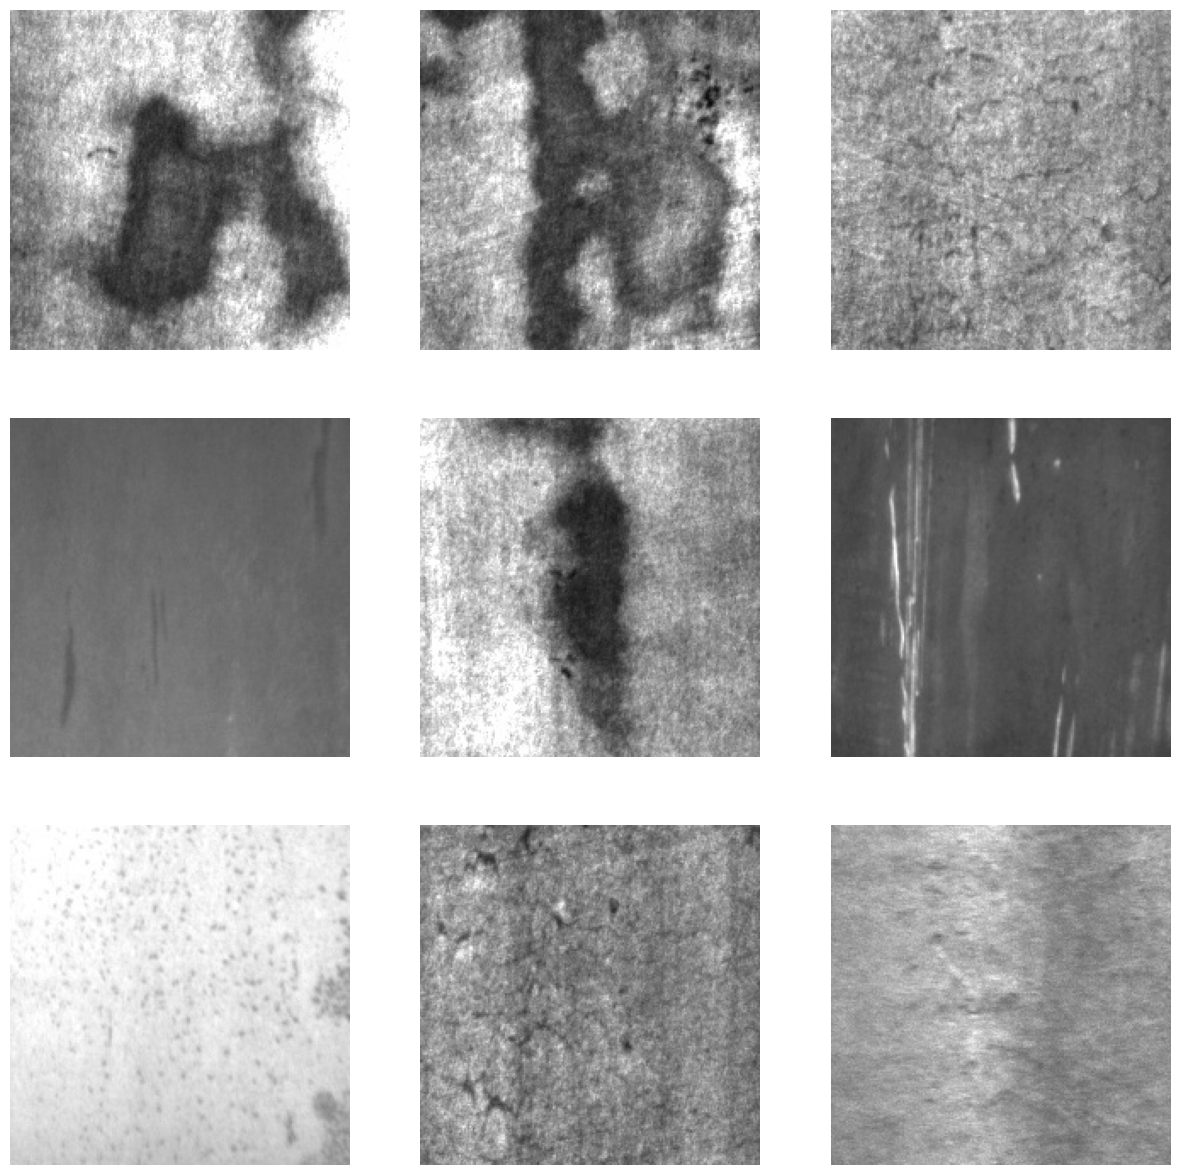

Class names: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [6]:
# Get a single batch from the generator
images, labels = next(train_data)

# Get the first image from the batch (index 0)
image = images[10]

# If you want to see the corresponding label
print("Label:", labels[0])

# To view multiple images from the batch
plt.figure(figsize=(15, 15))
for i in range(9):  # Display first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# You can also get class names from the generator
class_names = list(train_data.class_indices.keys())
print("Class names:", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction Shape: (1, 6)
Predicted class index: 4

Defect Classes:
{'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}

Number of classes: 6
Predicted class index: 4


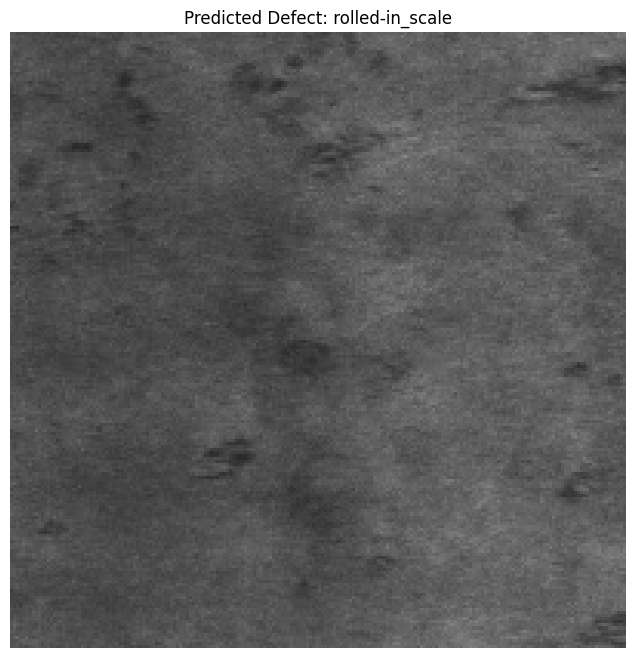

crazing: 0.13%
inclusion: 0.16%
patches: 0.02%
pitted_surface: 0.01%
rolled-in_scale: 99.65%
scratches: 0.03%


In [7]:
import numpy as np
# First, let's see what we have
images, labels = next(val_data)
single_image = images[2]
input_image = np.expand_dims(single_image, axis=0)

# Make prediction
predictions = model.predict(input_image)

print("Prediction Shape:", predictions.shape)
print("Predicted class index:", np.argmax(predictions[0]))
print("\nDefect Classes:")
print(train_data.class_indices)

predicted_class = np.argmax(predictions[0])
class_names = list(val_data.class_indices.keys())

print("\nNumber of classes:", len(class_names))
print("Predicted class index:", predicted_class)

# Now display with verification
plt.figure(figsize=(8, 8))
plt.imshow(single_image)
if predicted_class < len(class_names):
    plt.title(f'Predicted Defect: {class_names[predicted_class]}')
else:
    plt.title(f'Predicted Class Index: {predicted_class} (Warning: Index out of range)')
plt.axis('off')
plt.show()

# Print all probabilities
for i, prob in enumerate(predictions[0]):
    if i < len(class_names):
        print(f'{class_names[i]}: {prob:.2%}')
    else:
        print(f'Class {i}: {prob:.2%}')

In [8]:
model.save('TME_neu_model.keras')

##Model Evaluation

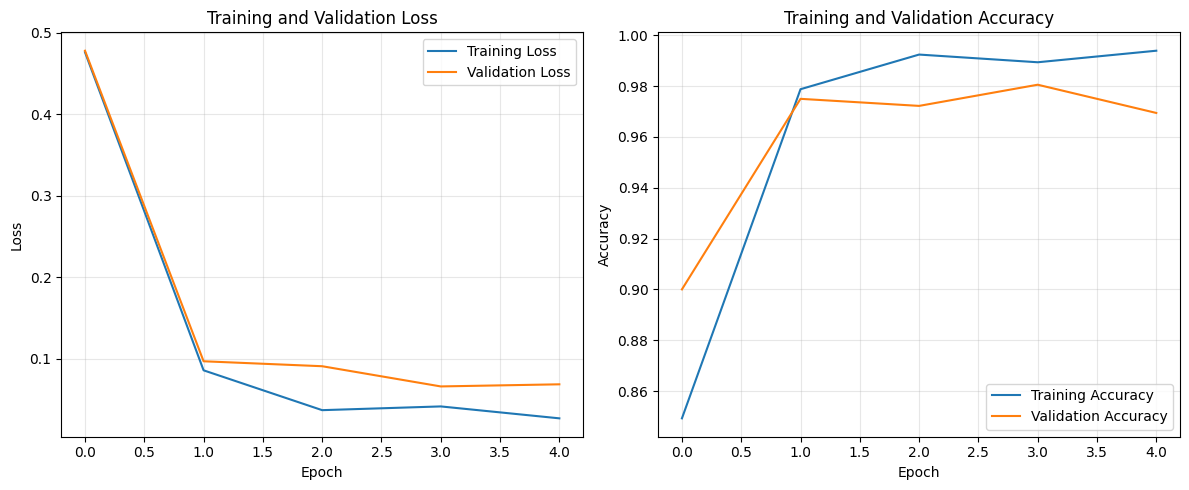

Found 120 images belonging to 6 classes.
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 2.0342e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9329 - loss: 0.2405
Test Loss: 0.1882
Test Accuracy: 0.9500
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step
Precision: 0.9615
Recall: 0.9500
F1 Score: 0.9488

Classification Report:
                 precision    recall  f1-score   support

        crazing       1.00      1.00      1.00        20
      inclusion       1.00      0.70      0.82        20
        patches       1.00      1.00      1.00        20
 pitted_surface       0.77      1.00      0.87        20
rolled-in_scale       1.00      1.00      1.00        20
      scratches       1.00      1.00      1.00        20

       accuracy                           0.95       120
      macro avg       0.96      0.95      0.95       120
   weighted avg       0.96      0.95      0.95       120



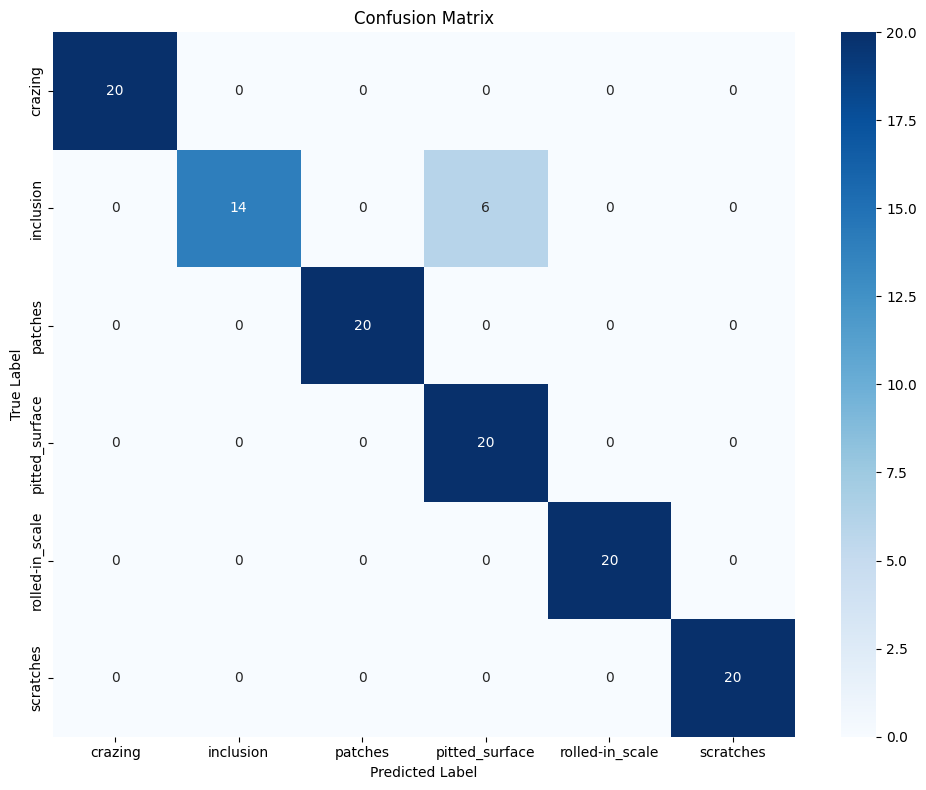

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


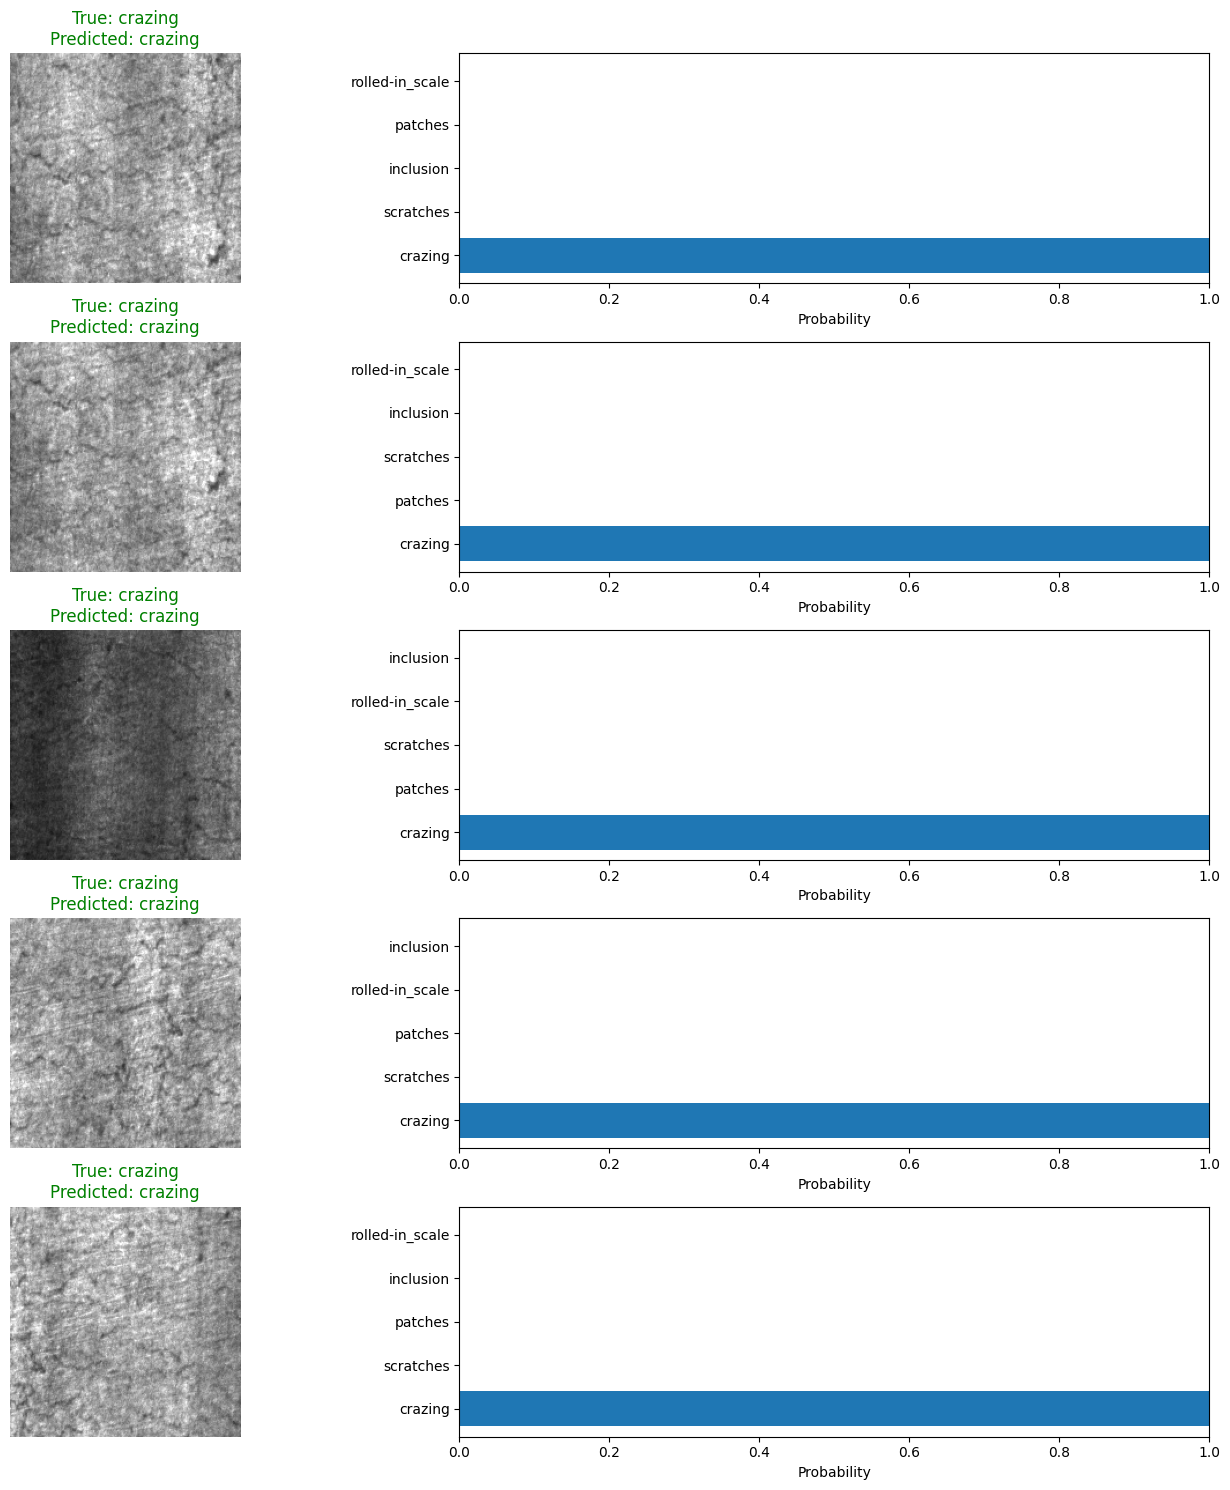

Mean Squared Error (MSE): 0.0147
Root Mean Squared Error (RMSE): 0.1211


In [9]:
##This is where evaluation will take place.
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns

# Plot the training history
def plot_loss_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call the function to plot training history
plot_loss_history(history)

# Create a test data generator
test_data = ImageDataGenerator(rescale=1./255)
test_generator = test_data.flow_from_directory(
    directory='NEU-DET/test/images',  # Using validation set as test set since no test set was specified
    target_size=(200, 200),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

# Get the class indices mapping
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
# Reset the generator before getting predictions
test_generator.reset()
y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Get true labels
test_generator.reset()
y_true = []
for i in range(len(test_generator)):
    batch_images, batch_labels = next(test_generator)
    for label in batch_labels:
        y_true.append(np.argmax(label))
    if len(y_true) >= len(y_pred_classes):
        break
y_true = y_true[:len(y_pred_classes)]  # Ensure same length

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Display some example predictions
def display_predictions(model, test_generator, class_names, num_examples=5):
    test_generator.reset()
    images, labels = next(test_generator)
    predictions = model.predict(images)

    plt.figure(figsize=(15, num_examples * 3))
    for i in range(min(num_examples, len(images))):
        plt.subplot(num_examples, 2, i*2 + 1)
        plt.imshow(images[i])
        plt.axis('off')
        true_class_idx = np.argmax(labels[i])
        pred_class_idx = np.argmax(predictions[i])
        true_class = class_names[true_class_idx]
        pred_class = class_names[pred_class_idx]
        title = f"True: {true_class}\nPredicted: {pred_class}"
        plt.title(title, color=("green" if true_class_idx == pred_class_idx else "red"))

        # Plot probability distribution
        plt.subplot(num_examples, 2, i*2 + 2)
        top_indices = np.argsort(predictions[i])[-5:][::-1]
        top_probs = predictions[i][top_indices]
        top_classes = [class_names[j] for j in top_indices]

        plt.barh(range(len(top_indices)), top_probs)
        plt.yticks(range(len(top_indices)), top_classes)
        plt.xlabel('Probability')
        plt.xlim([0, 1])

    plt.tight_layout()
    plt.show()

# Display some example predictions
display_predictions(model, test_generator, class_names)

# Compute MSE and RMSE (if needed, though less common for classification tasks)
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
mse = np.mean(np.square(y_true_one_hot - y_pred_prob))
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

##AUTOENCODER FOR DENOISING

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 100, 100, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 200, 200, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Found 1320 images belonging to 6 classes.
Found 120 images belonging to 6 classes.
Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - loss: 0.0230 - val_loss: 0.0393
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0031 - val_loss: 0.0395
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0029 - val_loss: 0.0315
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0023 - val_loss: 0.0292
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0023 - val_loss: 0.0247
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0021 - val_loss: 0.0223
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0020 - val_loss: 0.0300
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0022 - val_loss: 0.0200
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0019 - val_loss: 0.0192
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0018 - val_loss: 0.0218


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


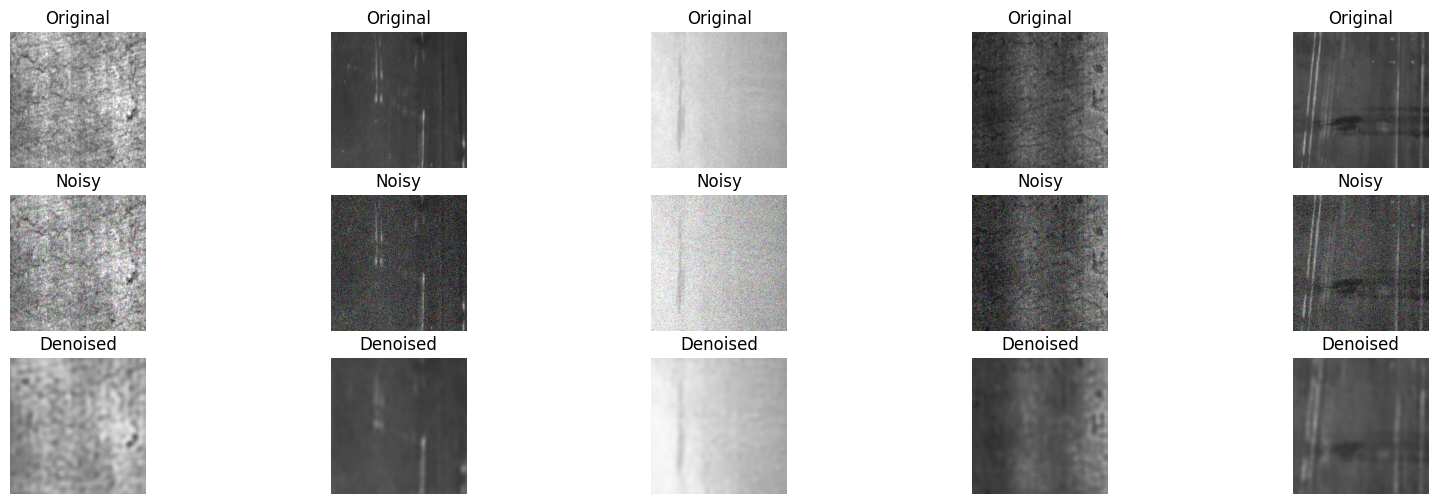

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the autoencoder architecture
def build_autoencoder(input_shape=(200, 200, 3)):
    # Encoder
    inputs = keras.Input(shape=input_shape)

    # Add Gaussian noise to simulate real-world noise (for training only)
    noisy_inputs = layers.GaussianNoise(0.1)(inputs)

    # Downsample
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(noisy_inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = keras.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Build the autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()

# Prepare data generators
train_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory='NEU-DET/train/images',
    target_size=(200, 200),
    batch_size=16,
    class_mode='categorical'
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory='NEU-DET/test/images',
    target_size=(200, 200),
    batch_size=16,
    class_mode='categorical'
)

# Custom generator that yields the same images as both input and target
def denoising_generator(generator):
    for batch_x, _ in generator:
        # For denoising, we use the same images as both input and target
        # The GaussianNoise layer will automatically add noise during training
        yield (batch_x, batch_x)

# Train the autoencoder
history = autoencoder.fit(
    denoising_generator(train_data),
    steps_per_epoch=len(train_data),
    epochs=50,
    validation_data=denoising_generator(test_data),
    validation_steps=len(test_data)
)

# Save the model
autoencoder.save('denoising_autoencoder.h5')

# Function to visualize results
import matplotlib.pyplot as plt

def visualize_results(model, generator, num_images=5):
    # Get a batch of test images
    test_images, _ = next(generator)

    # Add noise manually for visualization
    noisy_images = test_images + 0.1 * np.random.normal(size=test_images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)

    # Predict denoised images
    denoised_images = model.predict(noisy_images)

    # Display original, noisy and denoised images
    plt.figure(figsize=(20, 6))
    for i in range(num_images):
        # Original
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(test_images[i])
        plt.title("Original")
        plt.axis('off')

        # Noisy
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_images[i])
        plt.title("Noisy")
        plt.axis('off')

        # Denoised
        ax = plt.subplot(3, num_images, i + 1 + 2*num_images)
        plt.imshow(denoised_images[i])
        plt.title("Denoised")
        plt.axis('off')
    plt.show()

# Visualize some results
visualize_results(autoencoder, test_data)

##Testing AutoEncoder

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


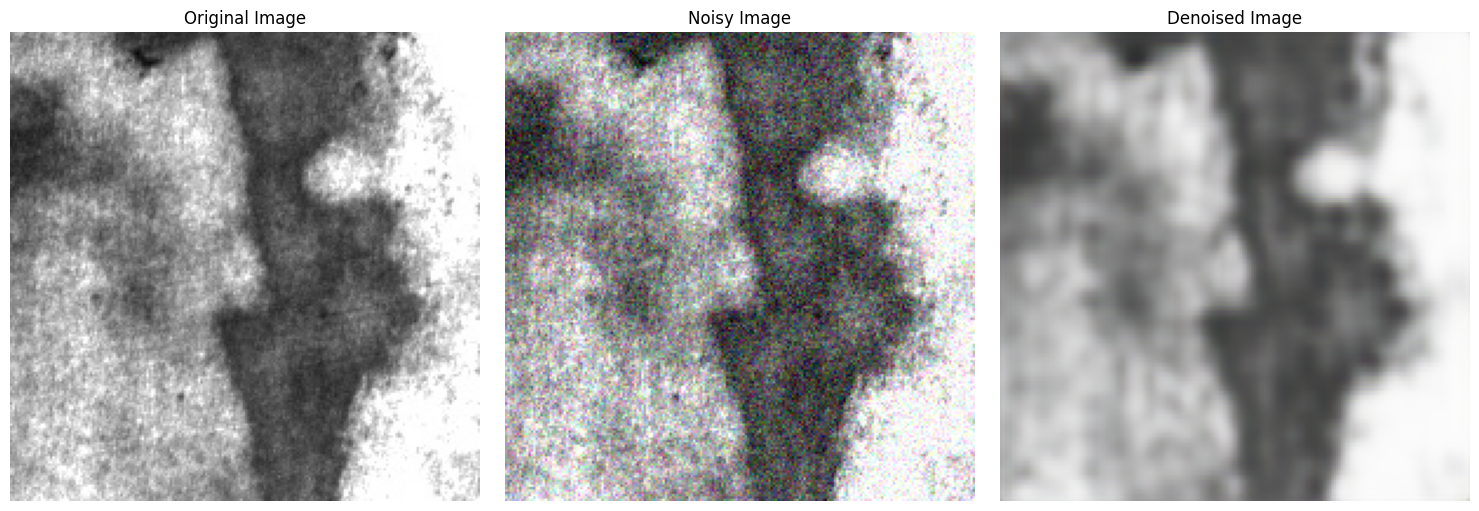

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained autoencoder model
autoencoder = tf.keras.models.load_model('denoising_autoencoder.h5', custom_objects = {'mse':tf.keras.losses.MeanSquaredError()})

def denoise_image(image_path, noise_level=0.1):
    """
    Denoise a single image using the trained autoencoder

    Args:
        image_path: Path to the image file
        noise_level: Amount of noise to add (for demonstration)

    Returns:
        original_image: The original loaded image
        noisy_image: The image with added noise
        denoised_image: The cleaned image after autoencoder
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(200, 200))
    original_image = image.img_to_array(img) / 255.0

    # # Add artificial noise (simulate noisy input)
    noisy_image = original_image + noise_level * np.random.normal(size=original_image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)  # Ensure pixel values stay between 0-1

    # Expand dimensions to create batch of size 1 (model expects batch dimension)
    # noisy_image_batch = np.expand_dims(original_image, axis=0)
    noisy_image_batch = np.expand_dims(noisy_image, axis=0)

    # Denoise the image
    denoised_image = autoencoder.predict(noisy_image_batch)[0]

    return original_image, noisy_image, denoised_image

# denoised_image = autoencoder.predict(noisy_image_batch)[0]

def display_results(original, noisy, denoised):
    """Display the original, noisy and denoised images side by side"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy)
    plt.title('Noisy Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denoised)
    plt.title('Denoised Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = 'patches_221.jpg'  # Replace with your image path
original, noisy, denoised = denoise_image(image_path)

# Display the results
display_results(original, noisy, denoised)

##DOWNSTREAM APPLICATION

In [19]:
# Install required packages
!pip install -q opencv-python matplotlib

from IPython.display import display, Javascript
from google.colab.output import eval_js
import matplotlib.pyplot as plt
import numpy as np
import cv2
from base64 import b64decode
import tensorflow as tf

def take_photo_for_model():
    # JS code to display webcam and capture button
    js = '''
    async function capturePhoto() {
      // Create elements
      const div = document.createElement('div');
      const video = document.createElement('video');
      const button = document.createElement('button');
      const img = document.createElement('img');

      // Setup button
      button.textContent = "Take Photo";
      button.style.display = "block";
      button.style.margin = "10px 0";
      button.style.padding = "8px 16px";
      button.style.backgroundColor = "#4CAF50";
      button.style.color = "white";
      button.style.border = "none";
      button.style.borderRadius = "4px";
      button.style.cursor = "pointer";

      // Add elements to DOM
      div.appendChild(video);
      div.appendChild(button);
      document.body.appendChild(div);

      // Get webcam stream
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      video.style.display = "block";
      video.style.width = "100%";
      video.style.maxWidth = "500px";
      video.style.border = "1px solid #ddd";
      await video.play();

      // Wait for button click
      const data = await new Promise(resolve => {
        button.onclick = () => {
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);

          // Get the data URL
          const dataUrl = canvas.toDataURL('image/jpeg');

          // Optionally show the captured photo
          img.src = dataUrl;
          img.style.display = "block";
          img.style.width = "100%";
          img.style.maxWidth = "500px";
          img.style.border = "1px solid #ddd";
          img.style.marginTop = "10px";

          // Show "Captured!" text on button
          button.textContent = "Captured!";
          button.style.backgroundColor = "#2196F3";

          // Turn off camera
          stream.getTracks().forEach(track => track.stop());

          // Hide video element
          video.style.display = "none";
          div.appendChild(img);

          // Return the data URL
          resolve(dataUrl);
        };
      });

      return data;
    }

    var data = capturePhoto();
    '''

    # Display the JavaScript
    display(Javascript(js))

    # Get the data back from JavaScript
    data = eval_js('data')

    # Convert base64 image to OpenCV format
    binary = b64decode(data.split(',')[1])
    image = np.asarray(bytearray(binary), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    return image

def save_captured_image(image, filename='captured_defect.jpg'):
    # Save the image to file
    cv2.imwrite(filename, image)
    print(f"Image saved as '{filename}'")
    return filename

def predict_defect_from_webcam():
    print("Please allow access to your webcam and click 'Take Photo' to capture the defect.")

    # Capture image
    captured_image = take_photo_for_model()

    # Save image
    image_path = save_captured_image(captured_image)

    #AutoEncoder
    Active_AutoEncoder = 1
    if Active_AutoEncoder == 1:
      original, noisy, denoised = denoise_image(image_path)
      # Convert the float array (0-1) to uint8 (0-255)
      array_uint8 = (denoised * 255).astype(np.uint8)
      # OpenCV uses BGR by default, so if your array is RGB, convert it
      array_bgr = cv2.cvtColor(array_uint8, cv2.COLOR_RGB2BGR)
      # Save the image
      image_path = "denoised_captured_defect.jpg"
      cv2.imwrite(image_path, array_bgr)
      display_results(original, noisy, denoised)

    # Use your existing prediction function
    # Implement AutoEncoder for Denoising
    # Call a main function that contains the AutoEncoder Pipeline.

    predict_defect(image_path)
    return image_path

# # Use the existing predict_defect function as-is
def predict_defect(image_path):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(200, 200))  # Use same size as training
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Same normalization as training
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Define class names - these should match your model's classes
    class_names = ['crazing', 'inclusion', 'patches', 'pitted', 'rolled', 'scratches']

    # Display image and prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Predicted Defect: {class_names[predicted_class]}')
    plt.axis('off')
    plt.show()

    # Print probabilities for all classes
    print("\nPrediction Probabilities:")
    for i, probability in enumerate(predictions[0]):
        print(f'{class_names[i]}: {probability:.2%}')

    return predicted_class, predictions[0]

Please allow access to your webcam and click 'Take Photo' to capture the defect.


<IPython.core.display.Javascript object>

Image saved as 'captured_defect.jpg'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


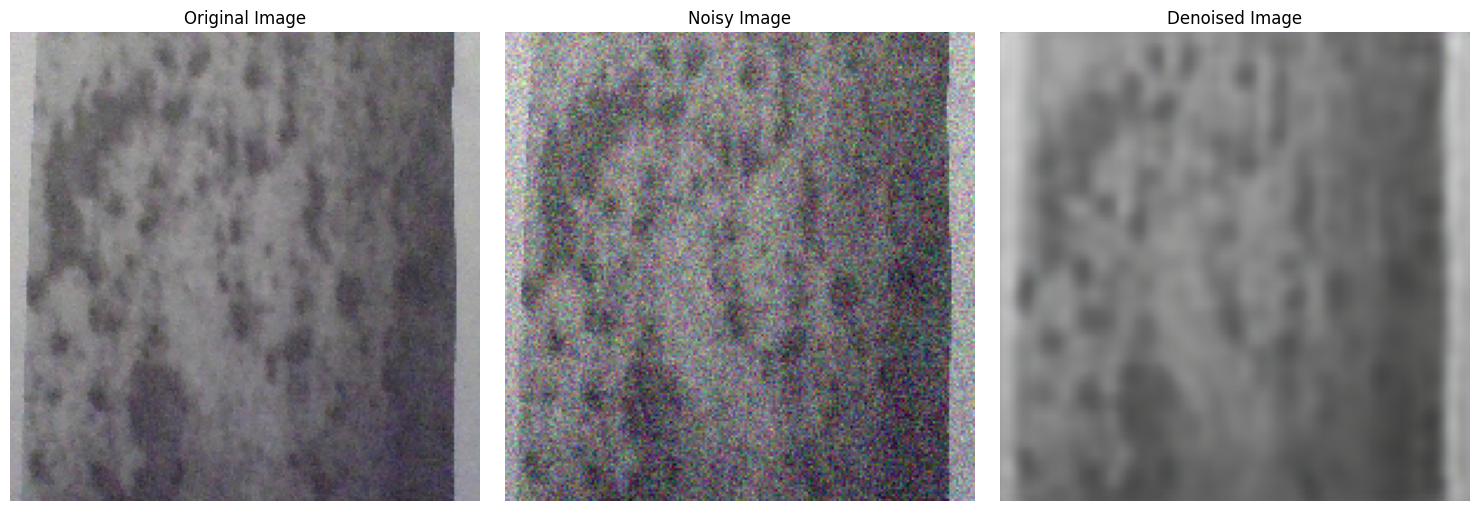

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


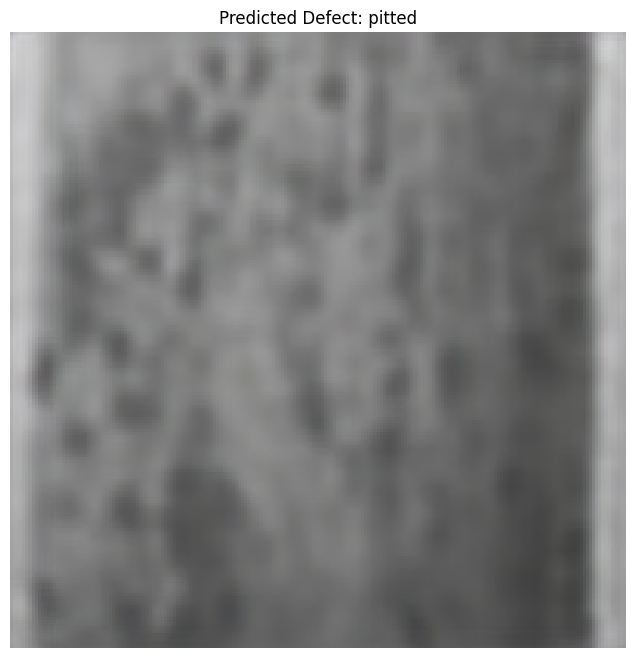


Prediction Probabilities:
crazing: 0.03%
inclusion: 0.79%
patches: 2.37%
pitted: 47.93%
rolled: 1.58%
scratches: 47.31%


'denoised_captured_defect.jpg'

In [21]:
# 1. Loading the model:
from keras.models import load_model
model = load_model('TME_neu_model.keras')
# 2. Then run this to capture an image and predict:
predict_defect_from_webcam()
